# Spoken Digit Recognition
Data from https://www.kaggle.com/alanchn31/free-spoken-digits

#Get the data from: 
https://www.kaggle.com/alanchn31/free-spoken-digits/download

You need only subfolder "recordings" with audio files

#For BlueHive Jupiter: 
Download this folder in your space (e.g., if you downloaded "Tutorial3a" in /home/YourNetId, you can copy there "recordings" folder). Change Kernel to PyTorch

#For Colab: 
For faster transmission, zip (compress) this folder to have "recordings.zip" Click on the left panell the image of folder and drag "recordings.zip" in the free space. Then run the following command (uncomment it)

In [2]:
#!unzip "recordings.zip" 

## Only for Colab: install torchaudio 
(it may ask to restart the Rumtime - see menu panel, - and run the line again)

In [1]:
!pip install torchaudio

## Import the packages

In [2]:
import torch
import torchaudio
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch import optim
from itertools import islice
from tqdm import tqdm
import pathlib
import matplotlib.pyplot as plt
from IPython.display import Audio

## Path to data:

In [3]:
path_to_data = pathlib.Path('./recordings')

## Create a list of paths to the train files and a list of paths to the test files

In [4]:
test_indexes = [] # np.zeros(2*600)
for i in range(60):
    #test_indexes[2*i:2*(i+1)] = np.random.choice(50, 2) + 50*i 
    test_indexes = test_indexes + list(np.random.choice(50, 2)+ 50*i)
train_indexes = [i for i in range(2900)]
train_indexes = list(set(train_indexes) - set(test_indexes))
paths = list(path_to_data.rglob('*.wav'))
paths_train = [paths[i] for  i in train_indexes] 
paths_test = [paths[i] for  i in test_indexes]

## Visualize audio data (optional)

In [5]:
#Take the first file from train set
wav, sr = torchaudio.load(paths_train[0].as_posix()) 
Audio(data=wav, rate=sr)

In [6]:
#It has an extra dimention, for visualisation we will "squeeze" it
wav.shape

torch.Size([1, 3472])

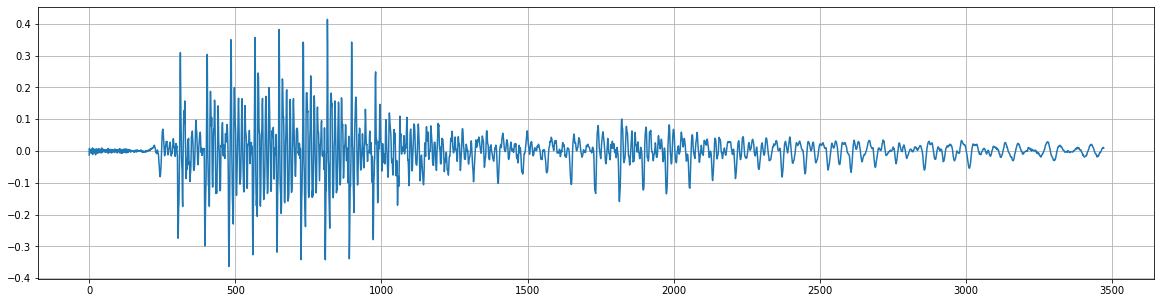

In [7]:
plt.figure(figsize=(20,5))
plt.plot(wav.squeeze())
plt.grid()

/usr/local/lib/python3.7/dist-packages/torch/functional.py:573: UserWarning: stft will soon require the return_complex parameter be given for real inputs, and will further require that return_complex=True in a future PyTorch release. (Triggered internally at  ../aten/src/ATen/native/SpectralOps.cpp:659.)
  normalized, onesided, return_complex)


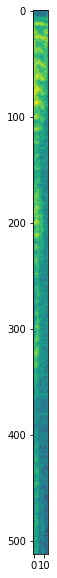

In [8]:
#Look at it's STFT
stft_wav = torch.stft( \
            input=wav, n_fft=1024, win_length=1024,hop_length=256, window=torch.hann_window(1024))
plt.figure(figsize=(20,10)) #you can make the second number bigger
plt.imshow(20*stft_wav.norm(dim=-1).squeeze().log10())

Reduce the number of frequencies, using Mel scale
$$m = 2595 \log_{10}\left( 1+ \frac{f}{700}\right)$$

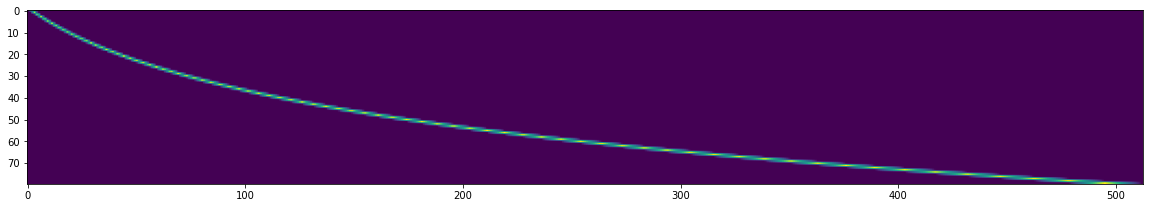

In [9]:
#We use 80 frequency bins
mel_scaler = torchaudio.transforms.MelScale(\
                        n_mels=80, sample_rate=16000, n_stft=1024//2+1)
#Plot the correspondence between linear and Mel scales
plt.figure(figsize=(20,10))
plt.imshow(mel_scaler.fb.T)

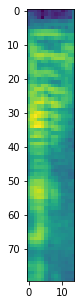

In [10]:
mel_wav = mel_scaler(stft_wav.norm(dim=-1))
plt.figure(figsize=(20,5))
plt.imshow(20*mel_wav.squeeze().log10())

## Create dataset class - returns Mel spectrogram and label of the digit

In [11]:
class AudioMnist(Dataset):
    def __init__(self, path_to_data):
        #self.path_to_data = pathlib.Path(path_to_data)
        #self.paths = list(self.path_to_data.rglob('*.wav'))
        self.paths = path_to_data
        self.featurizer = torchaudio.transforms.MelSpectrogram( \
            sample_rate=16000, n_fft=1024, win_length=1024,hop_length=256, n_mels=80)
        
    def __getitem__(self, index):
        path_to_wav = self.paths[index].as_posix()
        wav, _ = torchaudio.load(path_to_wav)
        mel_spec = self.featurizer(wav).squeeze(dim=0).clamp(1e-5).log()
        label = int(path_to_wav.split('/')[-1].split('_')[0])
        return mel_spec, label
        
    def __len__(self):
        return len(self.paths)

In [12]:
dataset = AudioMnist(paths_train)
dataset_test = AudioMnist(paths_test)

## Look at data with number 2


In [13]:
dataset[3]

(tensor([[-7.4836, -8.7265, -9.7360,  ..., -9.6033, -9.2899, -7.8818],
         [-7.3015, -8.5925, -8.7359,  ..., -9.5071, -9.2472, -7.4651],
         [-7.3872, -8.7584, -8.0902,  ..., -8.9507, -7.9760, -7.3875],
         ...,
         [-1.0657, -1.4273, -2.2417,  ..., -7.9234, -8.4040, -8.7694],
         [-0.5707, -0.9818, -2.2755,  ..., -8.6928, -8.5649, -8.4916],
         [-1.1349, -1.6249, -3.0275,  ..., -8.7563, -8.7837, -8.3095]]), 2)

## Listen to it

In [14]:
sig, sr = torchaudio.load(paths_train[3])
Audio(data=sig, rate=sr)

## Audio files have different lengths, when we combine them into one batch, we can zerro padd them to make of the same length

In [15]:
def collate_fn_padd(batch):
    '''
    Padds batch of variable length

    It converts data manually

    We padd with small values, to avoid log 0 = -inf
    '''
    data = torch.nn.utils.rnn.pad_sequence([item[0].transpose(-1,-2) for item in batch], batch_first=True, padding_value=np.log(1e-5))
    target = torch.LongTensor([item[1] for item in batch])
    
    return data.transpose(-1,-2), target

## Create dataloader - returns batches

In [16]:
dataloader = DataLoader(dataset, collate_fn=collate_fn_padd, shuffle=True, batch_size=32)

In [17]:
#you can look at the shape of the first batches
for i, batch in enumerate(dataloader):
    mel_spec, label = batch
    print(mel_spec.shape)
    if i == 2:
        break

torch.Size([32, 80, 29])
torch.Size([32, 80, 22])
torch.Size([32, 80, 26])


## Create model with one RNN module (we use only the last output) and one linear module with Softmax outputs (it normalizes 10 outputs to the values between 0 and 1)
Description of the LSTM module: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

In [18]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.LSTM(input_size=80, hidden_size=256, batch_first=True)
        self.fc = nn.Linear(256, 10)
        self.a = nn.Softmax(dim=1)
    def forward(self, input):
        output, _ = self.rnn(input.transpose(-1,-2))
        output = self.fc(output[:,-1])
        output = self.a(output)
        return output

## Check if there is GPU and if it is the case, send our data there

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#torch.cuda.is_available()

In [20]:
model = Model().to(device)

## Choose the optimizer and loss function

In [21]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
#For regression we used MSE, for classification we use
criterion = nn.CrossEntropyLoss()

## Training 
For faster training go to Runtime and change it to GPU mo

In [22]:
for epoc in range(10):
    for i, batch in tqdm(enumerate(dataloader)):
        mels, labels = batch
        logits = model(mels.to(device))
        loss = criterion(logits,labels.to(device)) #both inputs should be on the same device
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    #if i%50 ==0:
    print(loss.item())

88it [00:03, 26.21it/s]


1.9641755819320679


88it [00:01, 53.67it/s]


1.5300465822219849


88it [00:01, 52.90it/s]


1.466113805770874


88it [00:01, 52.40it/s]


1.480665683746338


88it [00:01, 52.52it/s]


1.4639537334442139


88it [00:01, 53.32it/s]


1.4620096683502197


88it [00:01, 52.96it/s]


1.4622342586517334


88it [00:01, 53.19it/s]


1.466660499572754


88it [00:01, 52.80it/s]


1.463151216506958


88it [00:01, 53.20it/s]

1.4692927598953247


## Now we can test our model on the unseen data (from the training set)

In [23]:
predict = []
target = []
for i in range(len(dataset_test)):
    #our model is on device, we send data to that device
    wav = dataset_test[i][0].unsqueeze(dim = 0).to(device) 
    #our target was on cpu, we sed the output on cpu
    predict.append(int(model(wav).detach().argmax().cpu().numpy())) 
    target.append(dataset_test[i][1])

In [24]:
from sklearn.metrics import accuracy_score
accuracy_score(predict, target)

1.0

## Save trained parameters of the model on the disk

In [28]:
torch.save(model.state_dict(), "weights.pth")

## It will create file "weights.pth" in your current directory. Save it on your drive because you will use it for prediction in a separate "test.py" file: see https://github.com/anton-selitskiy/NN_Tutorial
The link to download using wget: https://raw.githubusercontent.com/anton-selitskiy/NN_Tutorial/main/test.py